In [16]:
import time
import sys
sys.path.append('../utils')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import stellargraph as sg

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
# Load data

from load_data import load_data
v_data, e_data, core_target, ext_target = load_data()

In [3]:
# Subsample dataset

from tools import subsample
v_sample, e_sample, core_sample, ext_sample = subsample(v_data, e_data, core_target, ext_target, 20000)

## Feature Engineering

In [4]:
# 1: Missing Core/Extended case ID
# Attempt 1: set to 0 if NaN

v_sample.CoreCaseGraphID = v_sample.CoreCaseGraphID.fillna(0)
v_sample.ExtendedCaseGraphID = v_sample.ExtendedCaseGraphID.fillna(0)

/Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [5]:
# Check how many nodes I have

print(f"Nodes: {v_sample.count().values[0]} with {e_sample.count().values[0]} edges")

Nodes: 19071 with 10000 edges


In [6]:
# Create dataframes for each node type (Account, Customer, Derived entity, External entity, Address)
# and each edge type (has account, has address, is similar, money transfer)

v_sets = defaultdict()
for v_type in list(pd.Categorical(v_sample.Label).categories):
    v_sets[v_type] = v_sample[v_sample.Label == v_type]
    v_sets[v_type] = v_sets[v_type].drop(['Label', 'testingFlag']+list(v_sets[v_type].columns[v_sets[v_type].isnull().all()]), axis=1)

    e_sets = defaultdict()
for e_type in list(pd.Categorical(e_sample.Label).categories):
    e_sets[e_type] = e_sample[e_sample.Label == e_type]
    e_sets[e_type] = e_sets[e_type].drop(['Label']+list(e_sets[e_type].columns[e_sets[e_type].isnull().all()]), axis=1)
    e_sets[e_type] = e_sets[e_type].rename(columns={'from_id':'source', 'to_id':'target'})

In [7]:
# 2: Logical conversion from string to numeric (for categorical features)

#Revenue Size Flag: low, mid_low, medium, mid_high, high -> 1,2,3,4,5
conversion = {'low':1, 'mid_low':2, 'medium':3, 'mid_high':4, 'high':5}
for i in v_sets:
  if 'Revenue Size Flag' in list(v_sets[i].columns):
    v_sets[i]['Revenue Size Flag']=v_sets[i]['Revenue Size Flag'].map(conversion)
    
#Income Size Flag: low, medium, high -> 1,2,3
conversion = {'low':1, 'medium':2, 'high':3}
for i in v_sets:
  if 'Income Size Flag' in list(v_sets[i].columns):
    v_sets[i]['Income Size Flag']=v_sets[i]['Income Size Flag'].map(conversion)

#Similarity Strength: weak, medium, strong -> 1,2,3
conversion = {'weak':1, 'medium':2, 'strong':3}
for i in e_sets:
  if 'Similarity Strength' in list(e_sets[i].columns):
    e_sets[i]['Similarity Strength']= e_sets[i]['Similarity Strength'].map(conversion)
    e_sets[i] = e_sets[i].rename(columns={'Similarity Strength':'weight'})

#Amount Flag: small, medium, large -> 1,50,500 -> treated as weights
conversion = {'small':1, 'medium':50, 'large':500}
for i in e_sets:
  if 'Amount Flag' in list(e_sets[i].columns):
    e_sets[i]['Amount Flag']=e_sets[i]['Amount Flag'].map(conversion)
    e_sets[i] = e_sets[i].rename(columns={'Amount Flag':'weight'})
    

In [8]:
# 3: One-hot encoding for categorical features

for i in v_sets:
    if 'Person or Organisation' in list(v_sets[i].columns):
        v_sets[i] = pd.get_dummies(v_sets[i], columns=['Person or Organisation'])


In [9]:
# 4: String features
# Attempt 1: remove them

for i in v_sets:
    if 'Account ID String' in list(v_sets[i].columns):
      v_sets[i] = v_sets[i].drop('Account ID String', axis=1)
    if 'Address' in list(v_sets[i].columns):
      v_sets[i] = v_sets[i].drop('Address', axis=1)
    if 'Name' in list(v_sets[i].columns):
      v_sets[i] = v_sets[i].drop('Name', axis=1)


## StellarGraph setup

In [10]:
G = sg.StellarDiGraph(v_sets, e_sets)

In [11]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 19071, Edges: 10000

 Node types:
  Account: [11005]
    Features: float32 vector, length 3
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3365]
    Features: float32 vector, length 5
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [3071]
    Features: float32 vector, length 4
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1202]
    Features: float32 vector, length 4
    Edge types: none
  Address: [428]
    Features: float32 vector, length 2
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3252]
        Weights: range=[1, 500], mean=180.098, std=223.864
        Features: none
    Customer-has account->Account: [2940]
        Weights: all 1 (default)
        Features: none
    Derived Entity-money transfer->Acco

Number of random walks: 381420 in 170.64 s


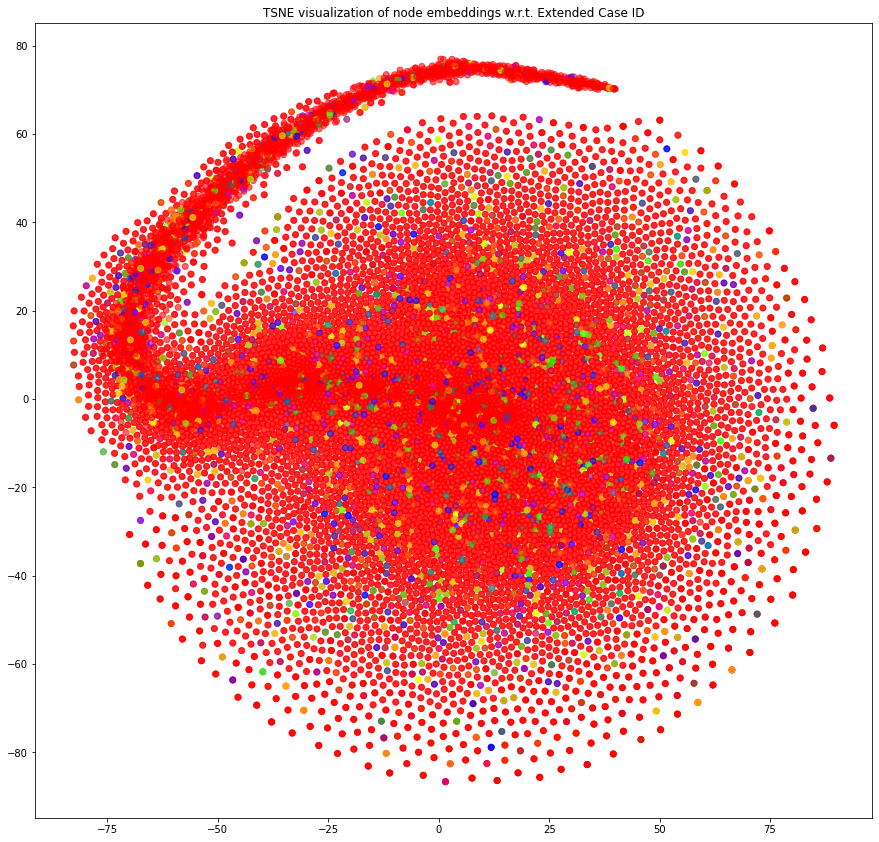

In [21]:
#### Graph embedding with NODE2VEC and WORD2VEC

rw = sg.data.BiasedRandomWalk(G)
t0 = time.time()
walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=10,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.6,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=1.7,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
t1 = time.time()
print("Number of random walks: {} in {:.2f} s".format(len(walks), (t1-t0)))


from gensim.models import Word2Vec
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=8, iter=5)
# size: length of embedding vector

# The embedding vectors can be retrieved from model.wv using the node ID.
# model.wv["19231"].shape 
  
# Retrieve node embeddings 
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality

# Retrieve corresponding targets

# from training csv
# core_targets = core_target_sample.loc[[int(node_id) for node_id in node_ids if int(node_id) in list(core_target_sample.index)]].CaseID
# ext_targets = ext_target_sample.loc[[int(node_id) for node_id in node_ids if int(node_id) in list(ext_target_sample.index)]].CaseID

# from vertices' data
core_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].CoreCaseGraphID
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID


In [34]:
core_targets

node_id
20030024109    0.0
150200944      0.0
15020030397    0.0
1502005007     0.0
2003009515     0.0
              ... 
20030014835    0.0
15020085338    0.0
15020052679    0.0
15020033299    0.0
3001169307     0.0
Name: CoreCaseGraphID, Length: 19071, dtype: float64

In [49]:
# Transform the embeddings to 2d space for visualization
transform = TSNE #PCA
trans = transform(n_components=2)
t2 = time.time()
node_embeddings_2d = trans.fit_transform(node_embeddings)
t3 = time.time()
print("dimensionality reduction done in {:.2} s".format(t3-t2))

dimensionality reduction done in 1.5e+02 s


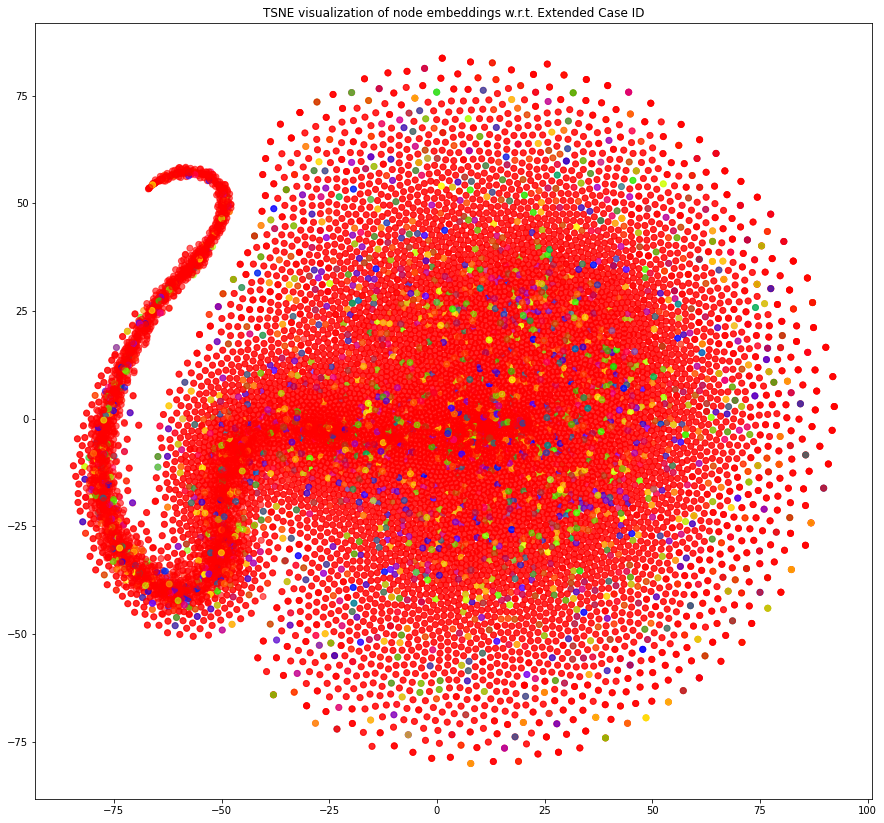

In [50]:
# Draw the embedding points, coloring them by the target label (CaseID)
alpha = 0.6
label_map = {l: i for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

plt.figure(figsize=(15, 15))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="prism",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings w.r.t. Extended Case ID".format(transform.__name__))
plt.show()

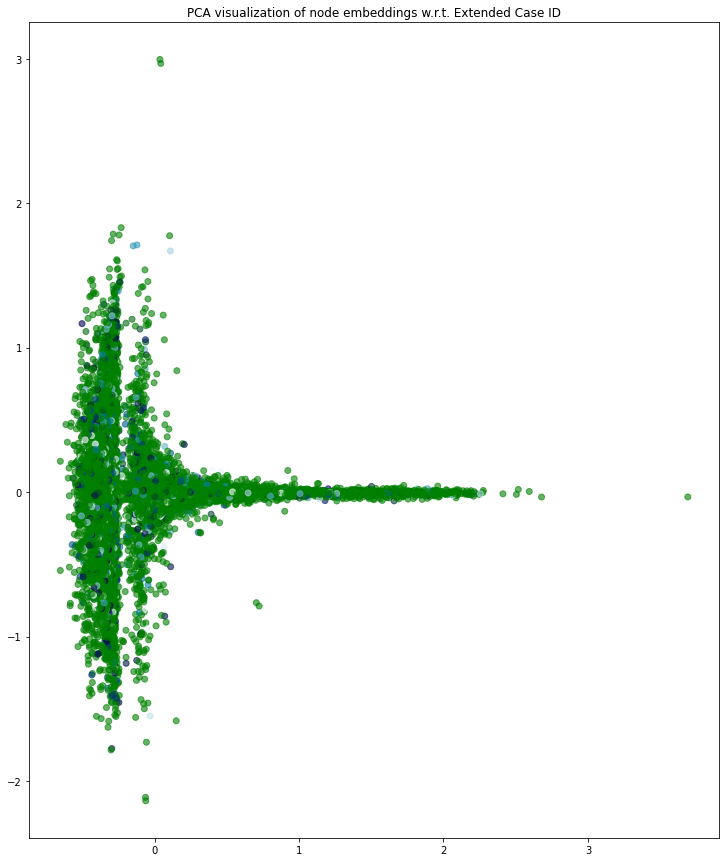

In [44]:
# Transform the embeddings to 2d space for visualization
transform = PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# Draw the embedding points, coloring them by the target label (CaseID)
alpha = 0.6
label_map = {l: i for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

plt.figure(figsize=(15, 15))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="ocean",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings w.r.t. Extended Case ID".format(transform.__name__))
plt.show()